<h1><center>F1 RACE PREDICTOR</center></h1>
<h1><center>3. Exploratory Data Analysis</center></h1>

---

## In this Notebook:

In this Notebook you will find the preliminary cleaning of the data and a quick feature engineering related to the use of dates and qualifying times. 

1. [Feature Creation](#1.-Feature_Creation)
2. [Dropping unnecessary columns and merging](#2.-Dropping_unnecessary_columns_and_merging)
3. [Data cleaning](#3.-Data_cleaning)
4. [Preliminary feature engineering](#4.-Feature_engineering_(preliminary))  
    4.1. [Drivers' age](Drivers'_age)  
    4.2. [Quali delta time](Qualifying_time_delta)

The following step after EDA is 4. ML Modelling.

---

In [18]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [19]:
df = pd.read_csv('data/df_no_dummies.csv')
df.columns

Index(['season', 'round', 'circuit_id', 'weather', 'weather_warm',
       'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy',
       'driver', 'nationality', 'constructor', 'grid', 'podium',
       'driver_points', 'driver_wins', 'driver_standings_pos',
       'constructor_points', 'constructor_wins', 'constructor_standings_pos',
       'qualifying_time', 'driver_age'],
      dtype='object')

In [20]:
# 'win' variable will be our target feature later in the modelling stage

df['win'] = df['podium'].apply(lambda x: 1 if x==1 else 0)

# 1. Feature Creation

##  1.1. Rain is a decisive weather feature

Many people call rain the great equalizer when it comes to F1 results. Drivers cannot go full throtle (and rely purely on the engine) and are forced to slow down and adapt their racing line, making the driver's skill more important to predict the result. As a consequence, wet conditions could help a good driver in a bad car to have a better-than-normal performance. This happened to George Russel (Williams team) in Spa in 2021, where he qualified 2nd. Other weather conditions are less important.

In [21]:
df['weather_wet'].value_counts(normalize=True)

0    0.895175
1    0.104825
Name: weather_wet, dtype: float64

## 1.2. Create regulation era categorical feature

In addition to our existing features, I consider important to include what F1 fans call the Regulation Era. This regulations dictated by the FIA dictate how teams should build their cars (type of engine, weight, aerodynamics, size, etc). In my opinion, this is a very important feature to take into account, as some teams can excel during a given era and go back to the midfield in another. An example of this is Mercedes undeniably dominating the V6 hybrid power unit era.

In [22]:
def era_split(value_in):
    if value_in<=1988:
        value_out = '1.5L_turbo'
    elif value_in<=1994:
        value_out = '3.5L_naturally_aspirated'
    elif value_in<=1999:
        value_out = '3L'
    elif value_in<=2005:
        value_out = 'V10'
    elif value_in<=2013:
        value_out = '2.4L_V8_engines'
    elif value_in<=2021:
        value_out = 'V6_hybrid'
    return value_out

In [23]:
df['reg_era'] = df.season.apply(era_split)
df[['reg_era']].value_counts(normalize=True)

reg_era                 
2.4L_V8_engines             0.213256
V6_hybrid                   0.207355
3.5L_naturally_aspirated    0.162384
1.5L_turbo                  0.157401
V10                         0.140947
3L                          0.118657
dtype: float64

# 2. Structure Investigation

## 2.1. Structure of categorical features

In [24]:
df.select_dtypes(include='object').describe()

circuit_id weather     driver nationality constructor          reg_era
count       15254   15254      15254       15254       15254            15254
unique         51     409        231          34          66                6
top         monza   Sunny  raikkonen     British     mclaren  2.4L_V8_engines
freq          883    1911        345        2229        1358             3253

## 2.2. Structure of numerical features

Let’s investigate how many unique values each numerical feature has. This process will give us some insights about the number of binary (2 unique values), ordinal (3 to ~10 unique values) and continuous (more than 10 unique values) features in the dataset.

<AxesSubplot:title={'center':'Unique values per numerical feature'}>

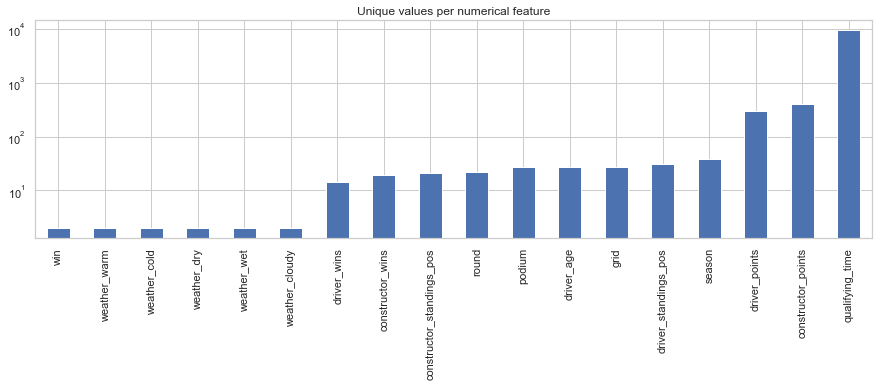

In [25]:
# How many unique values do the numerical features have?
unique_values = df.select_dtypes(include='number').nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15,4), title='Unique values per numerical feature')

###  Feature correlations

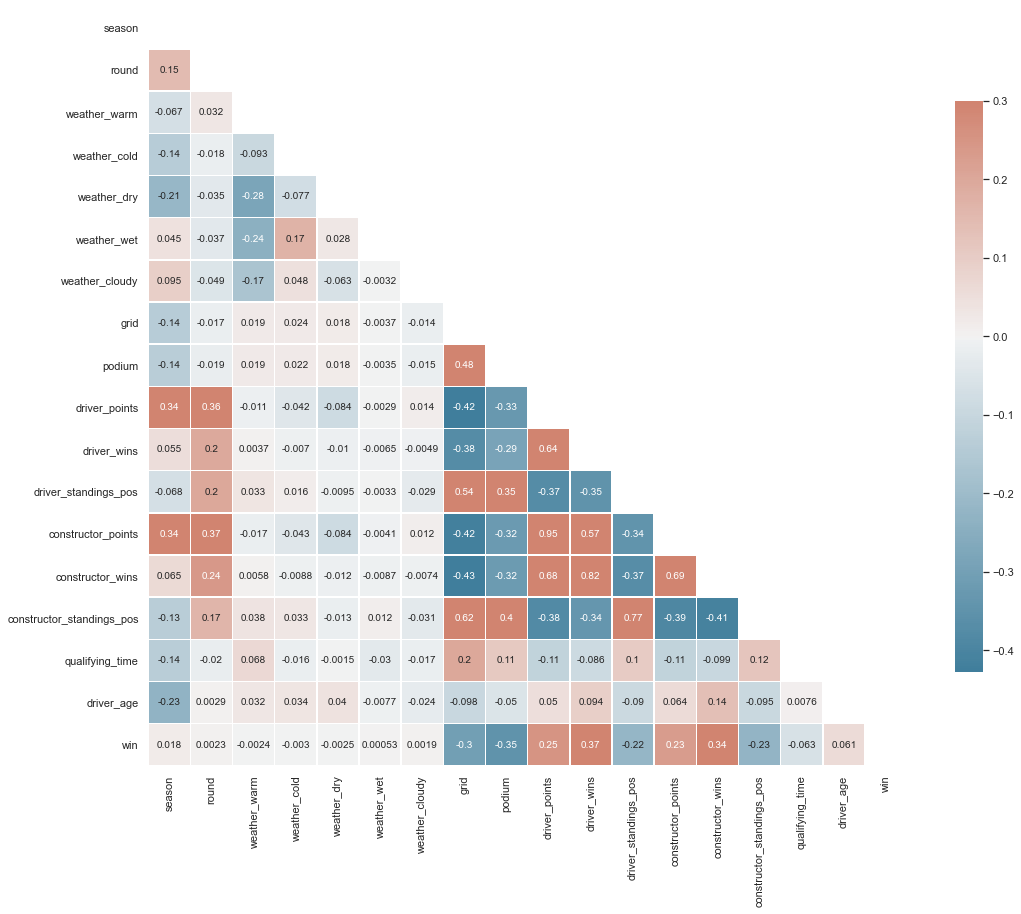

In [26]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(17, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True,  mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

plt.savefig('images/correlation_matrix.png')

### Observations about correlations

Weather features are not very correlated with final race position. I will drop them all but 'weather_wet' as I will use it for an analysis further down below.

In [27]:
df.drop(columns=['weather_warm','weather_cold', 'weather_dry', 'weather_cloudy'], inplace=True)

'reg_era' could be a useful categorical variable for the modeling stage later. We must be careful with multicollinearity.

# 3. Content Investigation

## 3.1 What are the most used circuits?

In [28]:
circuit_count = df.groupby(['circuit_id'])['circuit_id'].count().sort_values(ascending=False)/20 # Average of 20 drivers per race
circuit_count.head(10) # most used circuits in F1 history

circuit_id
monza             44.15
silverstone       42.30
monaco            41.55
spa               40.60
hungaroring       40.10
villeneuve        39.65
suzuka            34.50
hockenheimring    34.50
interlagos        33.95
catalunya         33.95
Name: circuit_id, dtype: float64

## 3.2. What are the 2021 circuits where quali matters the most?

In [29]:
grid_podium_corr = df.groupby('circuit_id')[['grid', 'podium']].corr().iloc[0::2,-1].sort_values(ascending=False)
grid_podium_corr = pd.DataFrame(grid_podium_corr).reset_index()

circuit_2021_list = list(df[df['season'] == 2021]['circuit_id'].unique())

grid_podium_corr_2021 = grid_podium_corr[grid_podium_corr.circuit_id.isin(circuit_2021_list)].reset_index(drop=True)
grid_podium_corr_2021

circuit_id level_1    podium
0        portimao    grid  0.827068
1        istanbul    grid  0.711489
2          jeddah    grid  0.687218
3         bahrain    grid  0.677431
4      yas_marina    grid  0.667388
5          losail    grid  0.609023
6       catalunya    grid  0.593835
7        americas    grid  0.587515
8           sochi    grid  0.586554
9     hungaroring    grid  0.528649
10     interlagos    grid  0.503947
11    silverstone    grid  0.493522
12           baku    grid  0.467974
13         ricard    grid  0.455840
14          monza    grid  0.439795
15      rodriguez    grid  0.439024
16         monaco    grid  0.432445
17            spa    grid  0.416074
18          imola    grid  0.403604
19  red_bull_ring    grid  0.394931
20      zandvoort    grid  0.318414

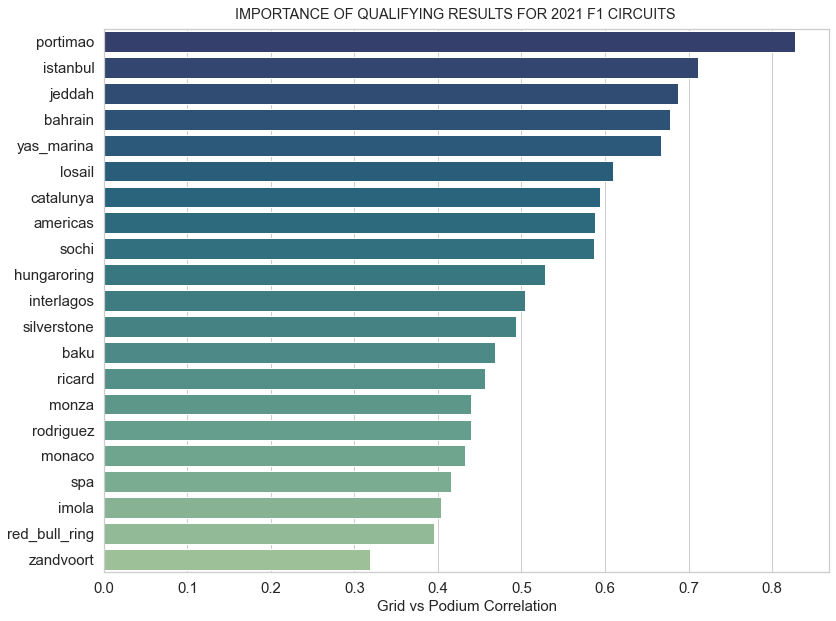

In [30]:
# plot highest grid-podium correlations

plt.figure(figsize=(13,10))
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=grid_podium_corr_2021, x='podium', y='circuit_id', palette='crest_r')
ax.set_xlabel ("Grid vs Podium Correlation", fontsize=15)
ax.set_ylabel ('') # drop y-axis label because it's distracting
ax.tick_params(labelsize=15)

plt.suptitle("IMPORTANCE OF QUALIFYING RESULTS FOR 2021 F1 CIRCUITS", y=0.91)

plt.savefig('images/podium-grid_correlation.png')

plt.show()

## 3.3. What is the best constructor? 

In [32]:
# account for team rebranding by replacing old names by new names

df.loc[df.constructor == "toro_rosso", "constructor"] = "alphatauri"
df.loc[df.constructor == "renault", "constructor"] = "alpine"
df.loc[df.constructor == "racing_point", "constructor"] = "aston_martin"
df.loc[df.constructor == "force_india", "constructor"] = "aston_martin"

constr_2021_list = list(df[df['season'] == 2021]['constructor'].unique()) # list of all 2021 constructors
df_2021_constr = df[df['constructor'].isin(constr_2021_list)] # list of all drivers that drove for those consturctors in 2021

In [33]:
# historically best constructor out of those competing in 2021 season

perf_constr_group = df.groupby(['constructor'])[['podium']].mean().sort_values(by=['podium'], ascending=True).reset_index()
perf_constr_group[perf_constr_group['constructor'].isin(constr_2021_list)]

constructor     podium
1       mercedes   5.739316
2       red_bull   7.779180
3        ferrari   7.951363
5        mclaren   9.010309
7         alpine  10.615160
8       williams  10.669139
12  aston_martin  11.533708
18    alphatauri  13.178631
24          alfa  14.237624
26          haas  14.333333

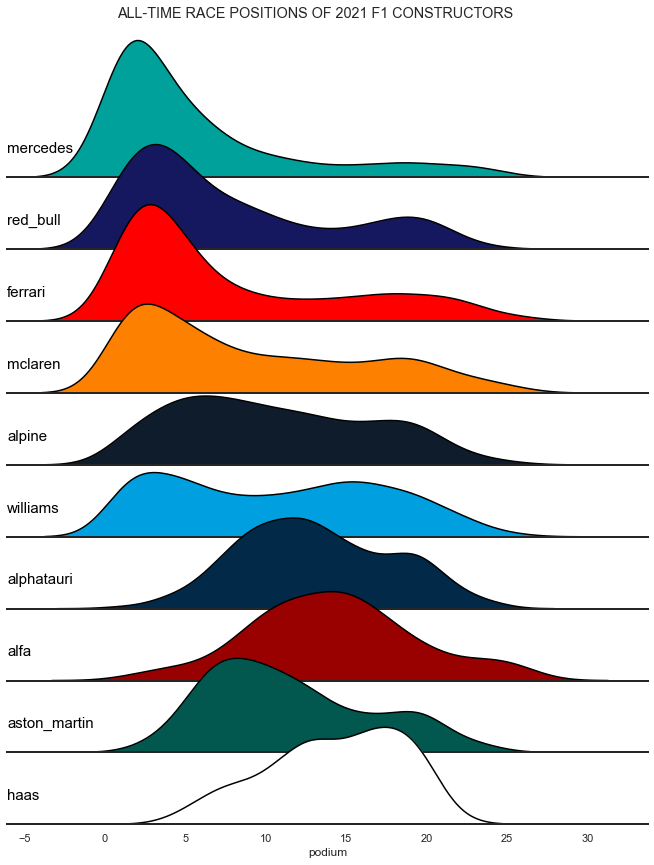

In [57]:
# plotting
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

row_order =   ['mercedes', 'red_bull', 'ferrari', 'mclaren', 'alpine', 'williams', 'alphatauri', 'alfa', 'aston_martin', 'haas']
hex_colors = ['#00a09b', '#15185f', '#fe0000', '#fd8000', '#0f1c2c','#00a0e0' , '#022948', '#990100', '#02584f', '#ffffff']

palette = {row_order[i]:hex_colors[i] for i in range(len(row_order))}

g = sns.FacetGrid(df_2021_constr, row='constructor', row_order=row_order, palette=palette, hue='constructor', aspect=8, height=1.2)

g.map_dataframe(sns.kdeplot, x='podium', fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x='podium', color='black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=15, ha="left", va="center", transform=ax.transAxes)
    
g.map(label, 'podium')

g.fig.subplots_adjust(hspace=-.5)

g.set_titles("")
g.set(yticks=[])
g.despine(left=True)

plt.suptitle("ALL-TIME RACE POSITIONS OF 2021 F1 CONSTRUCTORS", y=1)

plt.savefig('images/all_time_race_pos_by_constructor_2021.png')

## 3.4. What driver has the best performance?

### Overall

In [19]:
perf_all_group = df.groupby(['driver'])[['podium']].mean().sort_values(by=['podium'], ascending=True)
perf_all_group.head(10)

podium
driver                      
hamilton            4.712281
prost               6.379747
vettel              6.714286
max_verstappen      6.876812
michael_schumacher  6.885993
bottas              6.977273
senna               8.136646
rosberg             8.248780
alonso              8.346269
raikkonen           8.362319

In [20]:
perf_all = df[['driver', 'season', 'round', 'podium']].copy()
perf_all

driver  season  round  podium
0         keke_rosberg    1983      1      15
1                prost    1983      1       6
2               tambay    1983      1       4
3               piquet    1983      1       1
4              warwick    1983      1       7
...                ...     ...    ...     ...
15249           vettel    2021     22      11
15250           latifi    2021     22      16
15251          russell    2021     22      18
15252        raikkonen    2021     22      19
15253  mick_schumacher    2021     22      14

[15254 rows x 4 columns]

### Dry conditions

In [21]:
df_dry = df[df['weather_wet'] == 0]

perf_dry_group = df_dry.groupby(['driver'])[['weather_wet','podium']].mean().sort_values(by=['podium'], ascending=True)
perf_dry_group.head(10)

weather_wet    podium
driver                                   
hamilton                    0.0  4.725100
prost                       0.0  6.144828
vettel                      0.0  6.550000
bottas                      0.0  6.793750
michael_schumacher          0.0  6.802974
max_verstappen              0.0  7.032000
rosberg                     0.0  8.084270
raikkonen                   0.0  8.135922
alonso                      0.0  8.222603
montoya                     0.0  8.379310

### Wet conditions

In [22]:
df_wet = df[df['weather_wet'] == 1]

perf_wet_group = df_wet.groupby(['driver'])[['weather_wet','podium']].mean().sort_values(by=['podium'], ascending=True)
perf_wet_group.head(10)

weather_wet    podium
driver                               
senna                   1.0  3.000000
hamilton                1.0  4.617647
sullivan                1.0  5.000000
max_verstappen          1.0  5.384615
albon                   1.0  6.000000
baldi                   1.0  6.000000
bellof                  1.0  6.000000
angelis                 1.0  7.000000
serra                   1.0  7.000000
sainz                   1.0  7.285714

### Performace delta of the rain

This is how the presence of rain affects the performance of the top 30 drivers in dry conditions. Drivers like Senna, Webber and Gasly see an advantage in the presence of rain, whereas Prost, Vettel and Barrichello are hindered by it. 

In [23]:
perf_merged = perf_dry_group.merge(perf_wet_group, how='inner', left_on='driver', right_on='driver', suffixes=('_dry', '_wet')).drop(columns=['weather_wet_dry', 'weather_wet_wet'], axis=1)
perf_merged['rain_delta'] = perf_merged['podium_wet'] - perf_merged['podium_dry']
top_20_dry = perf_merged.sort_values(by='podium_dry').head(30)
top_20_dry.sort_values(by='rain_delta', ascending=True)

podium_dry  podium_wet  rain_delta
driver                                                
senna                 8.664384    3.000000   -5.664384
albon                 9.406250    6.000000   -3.406250
webber               10.069149    7.642857   -2.426292
max_verstappen        7.032000    5.384615   -1.647385
massa                 9.092827    7.593750   -1.499077
coulthard             9.583710    8.653846   -0.929864
damon_hill            8.990385    8.166667   -0.823718
villeneuve           10.306667    9.571429   -0.735238
perez                10.027027    9.363636   -0.663391
kubica               10.518072   10.076923   -0.441149
button                9.646840    9.513514   -0.133327
hamilton              4.725100    4.617647   -0.107453
hakkinen              9.597222    9.500000   -0.097222
gasly                10.527027   10.500000   -0.027027
michael_schumacher    6.802974    7.473684    0.670710
norris                8.862745    9.571429    0.708683
ralf_schumacher       9.783951   10.611111    0.827160
alonso                8.222603    9.186047    0.963444
mansell              10.193103   11.333333    1.140230
heidfeld             10.534161   11.727273    1.193111
ricciardo             9.497268   10.739130    1.241863
rosberg               8.084270    9.333333    1.249064
leclerc               8.535211    9.875000    1.339789
vettel                6.550000    7.909091    1.359091
montoya               8.379310   10.125000    1.745690
bottas                6.793750    8.812500    2.018750
piquet                9.038462   11.090909    2.052448
barrichello          10.003521   12.125000    2.121479
raikkonen             8.135922   10.305556    2.169633
prost                 6.144828    9.000000    2.855172

## 3.5. Consistency is key, but performance has to be good

### Driver consistency

In [24]:
# all time standard deviation of results for the 2021 season drivers

std_drivers = df.groupby(['driver'])['podium'].std().sort_values().reset_index() # calc std per driver
std_drivers = std_drivers.merge(df, how='inner', left_on='driver', right_on='driver', suffixes=('_std', '')) # join to obtain 2021 drivers
std_drivers = std_drivers[['driver', 'podium_std', 'season']] # pick out 2021 drivers
std_drivers = std_drivers[std_drivers['season'] == 2021].groupby(['driver'])[['podium_std']].mean().sort_values(by='podium_std', ascending=True) # regroup
std_drivers

podium_std
driver                     
mazepin            1.729299
mick_schumacher    2.136064
giovinazzi         3.027538
latifi             3.100014
russell            3.255315
stroll             4.375890
tsunoda            4.533791
norris             4.536102
ocon               4.834884
gasly              4.914643
sainz              4.928715
perez              4.955437
bottas             5.504237
hamilton           5.704090
leclerc            5.819335
ricciardo          5.943512
kubica             6.059211
raikkonen          6.148764
alonso             6.241601
max_verstappen     6.263616
vettel             6.469872

### Constructor consistency

In [25]:
# all time standard deviation of results for the 2021 season constructors

std_constructors = df.groupby(['constructor'])['podium'].std().sort_values().reset_index() # calc std per constructor
std_constructors = std_constructors.merge(df, how='inner', left_on='constructor', right_on='constructor', suffixes=('_std', '')) # join to obtain 2021 constructors
std_constructors = std_constructors[['constructor', 'podium_std', 'season']] # pick out 2021 drivers
std_constructors = std_constructors[std_constructors['season'] == 2021].groupby(['constructor'])[['podium_std']].mean().sort_values(by='podium_std', ascending=True) # regroup
std_constructors

podium_std
constructor             
haas            4.164019
alphatauri      4.706056
aston_martin    5.027671
alfa            5.098334
mercedes        5.982522
alpine          6.000779
red_bull        6.316193
williams        6.657739
mclaren         6.947951
ferrari         6.951623